#Face Mask Detection Dataset from Kaggle

Dataset available here: https://www.kaggle.com/datasets/omkargurav/face-mask-dataset/data

##Transfer Learning with MobileNetV2

1. Import Libraries

In [46]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
tf.__version__

'2.18.0'

2. Extract file

In [66]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [67]:
!unzip /content/drive/MyDrive/_JEDHA_DATASCIENCE/DEEP_LEARNING/CNN/face_mask_detection/archive.zip

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: data/with_mask/with_mask_3297.jpg  
  inflating: data/with_mask/with_mask_3298.jpg  
  inflating: data/with_mask/with_mask_3299.jpg  
  inflating: data/with_mask/with_mask_33.jpg  
  inflating: data/with_mask/with_mask_330.jpg  
  inflating: data/with_mask/with_mask_3300.jpg  
  inflating: data/with_mask/with_mask_3301.jpg  
  inflating: data/with_mask/with_mask_3302.jpg  
  inflating: data/with_mask/with_mask_3303.jpg  
  inflating: data/with_mask/with_mask_3304.jpg  
  inflating: data/with_mask/with_mask_3305.jpg  
  inflating: data/with_mask/with_mask_3306.jpg  
  inflating: data/with_mask/with_mask_3307.jpg  
  inflating: data/with_mask/with_mask_3308.jpg  
  inflating: data/with_mask/with_mask_3309.jpg  
  inflating: data/with_mask/with_mask_331.jpg  
  inflating: data/with_mask/with_mask_3310.jpg  
  inflating: data/with_mask/with_mask_3311.jpg  
  inflating: data/with_mask/with_mask_3312.j

##Preprocessing with ImageDataGenerator

In [169]:
img_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    brightness_range=(0.5,1),
    channel_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    rescale=1./255,
    validation_split=0.3)


In [170]:
img_generator_flow_train = img_generator.flow_from_directory(
    directory="/content/data",
    target_size=(224, 224),
    batch_size=32,
    shuffle=True,
    class_mode="binary",
    subset="training")

img_generator_flow_valid = img_generator.flow_from_directory(
    directory="/content/data",
    target_size=(224, 224),
    batch_size=32,
    shuffle=False,
    class_mode="binary",
    subset="validation")


Found 5288 images belonging to 2 classes.
Found 2265 images belonging to 2 classes.


In [171]:
# Print class labels
print(img_generator_flow_train.class_indices)

{'with_mask': 0, 'without_mask': 1}


## Visualize batch of images

In [172]:
import matplotlib.pyplot as plt
import numpy as np

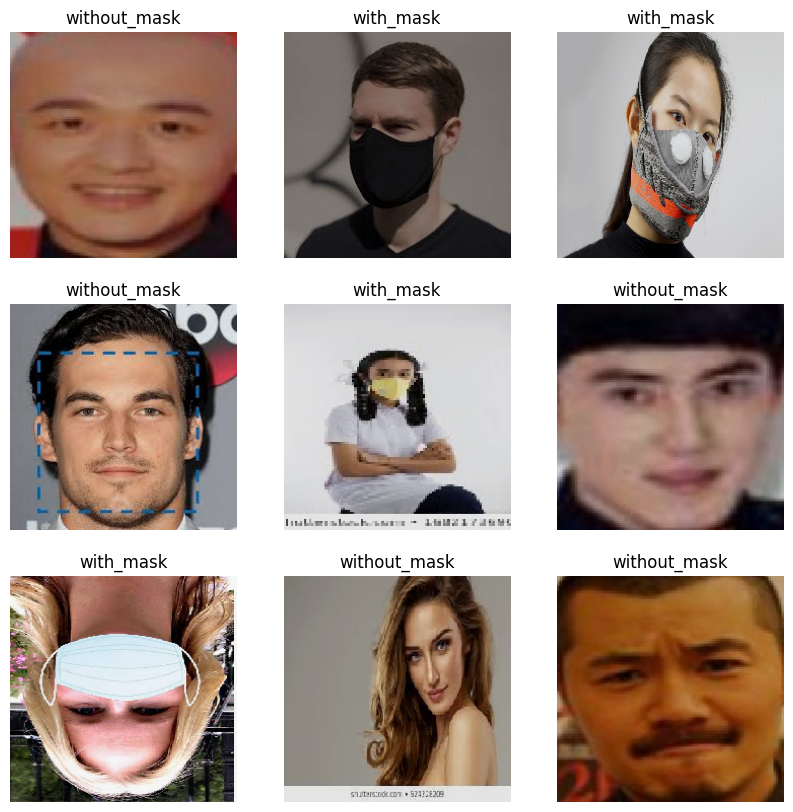

In [155]:
imgs, labels = next(iter(img_generator_flow_train))

fig, axes = plt.subplots(3, 3, figsize=(10, 10))

class_labels = list(img_generator_flow_train.class_indices.keys())

for i, ax in enumerate(axes.flat):
    if i < len(imgs):
        img = imgs[i]
        label = class_labels[np.argmax(labels[i])]
        ax.imshow(img)
        ax.set_title(label)
        ax.axis("off")
plt.show()

#Transfer Learning

Load Pretrained MobileNetV2

In [185]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [186]:
#Load MobileNetV2 (pre-trained on ImageNet), remove top layers
base_model = MobileNetV2(input_shape=(224,224,3),
                         include_top=False,
                         weights = "imagenet")

Freeze the base model's layers (to retain pre-trained knowledge)

In [187]:
base_model.trainable = False

## Let's add custom layers

In [190]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output_layer = Dense(1, activation='sigmoid')(x)

In [191]:
model = Model(inputs=base_model.input, outputs=output_layer)

In [192]:
# Model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
              loss='binary_crossentropy',
              metrics=['accuracy']
              )

In [193]:
model.summary()

Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_15            │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer_15[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

#Let's train our model

In [197]:
history = model.fit(img_generator_flow_train,
                    validation_data=img_generator_flow_valid,
                    steps_per_epoch=20,
                    epochs=20)


Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 80s 4s/step - accuracy: 0.9586 - loss: 0.1101 - val_accuracy: 0.9611 - val_loss: 0.1004
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 100s 5s/step - accuracy: 0.9663 - loss: 0.0768 - val_accuracy: 0.9629 - val_loss: 0.0896
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 78s 4s/step - accuracy: 0.9774 - loss: 0.0596 - val_accuracy: 0.9594 - val_loss: 0.0886
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 78s 4s/step - accuracy: 0.9659 - loss: 0.0678 - val_accuracy: 0.9408 - val_loss: 0.1456
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 89s 5s/step - accuracy: 0.9700 - loss: 0.0891 - val_accuracy: 0.9541 - val_loss: 0.1144
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 81s 4s/step - accuracy: 0.9812 - loss: 0.0544 - val_accuracy: 0.9651 - val_loss: 0.0856
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 99s 5s/step - accuracy: 0.9515 - loss: 0.1084 - val_accuracy: 0.9625 - val_loss: 0.0968
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 80s 4s/step - accuracy: 0.9731 - loss: 0.0890 - val_accuracy: 0.9687 - val_loss

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


20/20 ━━━━━━━━━━━━━━━━━━━━ 68s 4s/step - accuracy: 0.9729 - loss: 0.0786 - val_accuracy: 0.9682 - val_loss: 0.0792
Epoch 10/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 82s 4s/step - accuracy: 0.9766 - loss: 0.0627 - val_accuracy: 0.9501 - val_loss: 0.1222
Epoch 11/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 82s 4s/step - accuracy: 0.9784 - loss: 0.0593 - val_accuracy: 0.9673 - val_loss: 0.0862
Epoch 12/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 87s 5s/step - accuracy: 0.9601 - loss: 0.1006 - val_accuracy: 0.9576 - val_loss: 0.1020
Epoch 13/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 100s 5s/step - accuracy: 0.9733 - loss: 0.0681 - val_accuracy: 0.9669 - val_loss: 0.0822
Epoch 14/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 83s 4s/step - accuracy: 0.9675 - loss: 0.0826 - val_accuracy: 0.9634 - val_loss: 0.0896
Epoch 15/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 83s 4s/step - accuracy: 0.9809 - loss: 0.0682 - val_accuracy: 0.9731 - val_loss: 0.0701
Epoch 16/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 80s 4s/step - accuracy: 0.9699 - loss: 0.0819 - val_accuracy: 0.9704 - val_loss: 0.

##Save Model

In [263]:
model.save("/content/drive/MyDrive/_JEDHA_DATASCIENCE/DEEP_LEARNING/CNN/face_mask_detection/face_mask_mobilenetv2_binary.h5")

In [269]:
import matplotlib.pyplot as plt

# Extract accuracy and loss from training history
train_acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
train_loss = history.history["loss"]
val_loss = history.history["val_loss"]

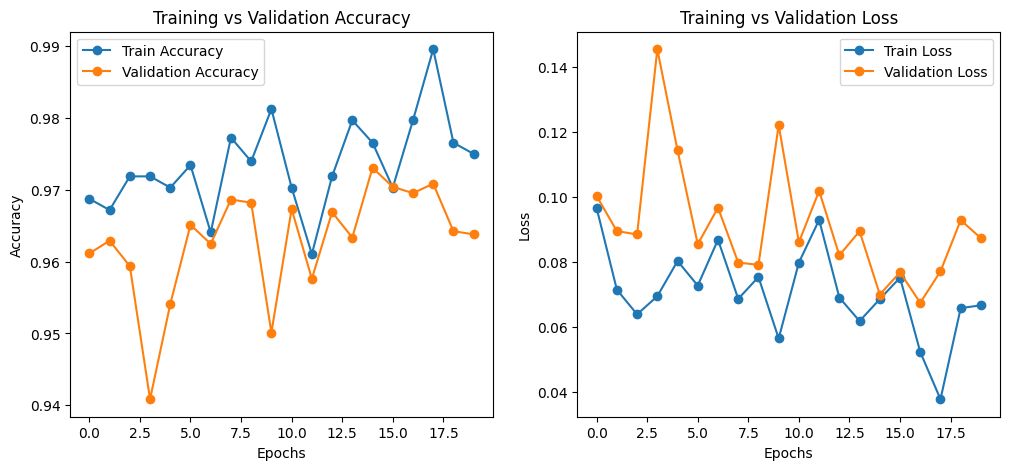

In [274]:
# Create subplots for accuracy and loss
plt.figure(figsize=(12, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(train_acc, label="Train Accuracy", marker="o")
plt.plot(val_acc, label="Validation Accuracy", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(train_loss, label="Train Loss", marker="o")
plt.plot(val_loss, label="Validation Loss", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()

plt.show()

## Fine-Tune MobileNetV2 (Unfreeze Last Layers)

In [265]:
base_model.trainable = True

In [266]:
for layer in base_model.layers[:100]:
    layer.trainable = False

In [267]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

In [268]:
history_fine_tune = model.fit(img_generator_flow_train, validation_data=img_generator_flow_valid, epochs=5)

Epoch 1/5
 54/166 ━━━━━━━━━━━━━━━━━━━━ 1:42 914ms/step - accuracy: 0.9860 - loss: 0.0402

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


166/166 ━━━━━━━━━━━━━━━━━━━━ 223s 1s/step - accuracy: 0.9842 - loss: 0.0453 - val_accuracy: 0.9735 - val_loss: 0.0688
Epoch 2/5
166/166 ━━━━━━━━━━━━━━━━━━━━ 208s 1s/step - accuracy: 0.9848 - loss: 0.0459 - val_accuracy: 0.9673 - val_loss: 0.0762
Epoch 3/5
166/166 ━━━━━━━━━━━━━━━━━━━━ 201s 1s/step - accuracy: 0.9817 - loss: 0.0557 - val_accuracy: 0.9722 - val_loss: 0.0717
Epoch 4/5
166/166 ━━━━━━━━━━━━━━━━━━━━ 203s 1s/step - accuracy: 0.9837 - loss: 0.0457 - val_accuracy: 0.9642 - val_loss: 0.0851
Epoch 5/5
166/166 ━━━━━━━━━━━━━━━━━━━━ 203s 1s/step - accuracy: 0.9823 - loss: 0.0517 - val_accuracy: 0.9678 - val_loss: 0.0726


In [272]:
# Save fine-tuned model
model.save("/content/drive/MyDrive/_JEDHA_DATASCIENCE/DEEP_LEARNING/CNN/face_mask_detection/face_mask_mobilenetv2_finetuned_binary.h5")



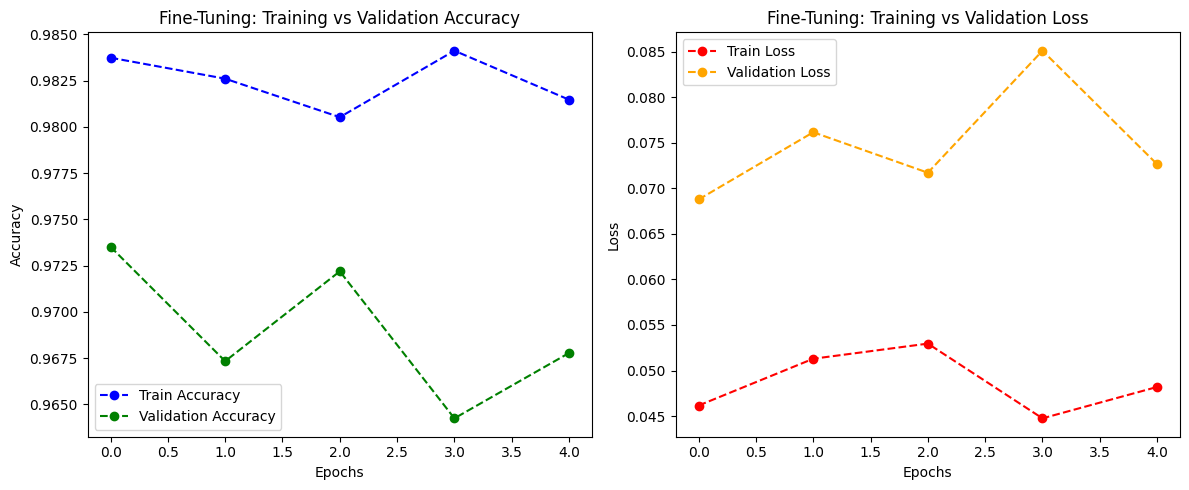

In [273]:
import matplotlib.pyplot as plt

# Extract fine-tuning history
fine_train_acc = history_fine_tune.history["accuracy"]
fine_val_acc = history_fine_tune.history["val_accuracy"]
fine_train_loss = history_fine_tune.history["loss"]
fine_val_loss = history_fine_tune.history["val_loss"]

# Create subplots for accuracy and loss
plt.figure(figsize=(12, 5))

# Plot Fine-Tuning Accuracy
plt.subplot(1, 2, 1)
plt.plot(fine_train_acc, label="Train Accuracy", marker="o", linestyle="--", color="blue")
plt.plot(fine_val_acc, label="Validation Accuracy", marker="o", linestyle="--", color="green")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Fine-Tuning: Training vs Validation Accuracy")
plt.legend()

# Plot Fine-Tuning Loss
plt.subplot(1, 2, 2)
plt.plot(fine_train_loss, label="Train Loss", marker="o", linestyle="--", color="red")
plt.plot(fine_val_loss, label="Validation Loss", marker="o", linestyle="--", color="orange")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Fine-Tuning: Training vs Validation Loss")
plt.legend()

plt.tight_layout()
plt.show()
